# Assignment 2: RNN
**Group 15:** Anil Lingala (akl180001), Kenneth Ly (kll200003), Anshuman Das (axd210123), Parisa Nawar (pxn210032)  
**CS 6320.001**  
**10/17/25**  

*NOTE: I recommend to set the runtime type to T4 GPU if you dont want training to take too long  
(click the drop down on the top right and click change runtime type)


# Setup
Importing libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
import math
import random
import os
import time
from tqdm import tqdm
import json
import string
from argparse import ArgumentParser
import pickle

# RNN Class
The class representing the RNN and the forward method we implemented to perform the forwardpass for the network

In [ ]:
unk = '<UNK>'
# Consult the PyTorch documentation for information on the functions used below:
# https://pytorch.org/docs/stable/torch.html
class RNN(nn.Module):
    def __init__(self, input_dim, h):  # Add relevant parameters
        super(RNN, self).__init__()
        self.h = h
        self.numOfLayer = 1
        self.rnn = nn.RNN(input_dim, h, self.numOfLayer, nonlinearity='tanh')
        self.W = nn.Linear(h, 5)
        self.softmax = nn.LogSoftmax(dim=1)
        self.loss = nn.NLLLoss()

    def compute_Loss(self, predicted_vector, gold_label):
        return self.loss(predicted_vector, gold_label)

    def forward(self, inputs):
      # [to fill] obtain hidden layer representation (https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)
      output, hidden = self.rnn(inputs)

      # [to fill] obtain output layer representations
      logits = self.W(output)

      # [to fill] sum over output
      summedLogits = torch.sum(logits, dim=0)

      # [to fill] obtain probability dist.
      predicted_vector = self.softmax(summedLogits)

      return predicted_vector

# Helper Utility Functions

In [ ]:
# Returns:
# vocab = A set of strings corresponding to the vocabulary
def make_vocab(data):
    vocab = set()
    for document, _ in data:
        for word in document:
            vocab.add(word)
    return vocab

In [ ]:
def load_data(train_data, val_data):
    with open(train_data) as training_f:
        training = json.load(training_f)
    with open(val_data) as valid_f:
        validation = json.load(valid_f)

    tra = []
    val = []
    for elt in training:
        tra.append((elt["text"].split(),int(elt["stars"]-1)))
    for elt in validation:
        val.append((elt["text"].split(),int(elt["stars"]-1)))
    return tra, val

In [ ]:
os.makedirs("results", exist_ok=True)
def log_print(*args, **kwargs):
    print(*args, **kwargs)

    with open("results/test_rnn.out", "a") as output:
        print(*args, **kwargs, file=output)

# Layers and parameters definitions
We can tweak the arguments and random seeds used by the network

In [ ]:
# Put argumentvalues here
hidden_dim_array = [1, 4, 16, 32, 64, 128]
epochs = 20
trials = 3
do_train = 'yes'

# Path to datasets
train_data_path = "training.json"
val_data_path = "validation.json"
test_data_path = "test.json"


# Load and Vectorize Data

In [ ]:
print("========== Loading data ==========")
train_data, valid_data = load_data(train_data_path, val_data_path) # X_data is a list of pairs (document, y); y in {0,1,2,3,4}

# Think about the type of function that an RNN describes. To apply it, you will need to convert the text data into vector representations.
# Further, think about where the vectors will come from. There are 3 reasonable choices:
# 1) Randomly assign the input to vectors and learn better embeddings during training; see the PyTorch documentation for guidance
# 2) Assign the input to vectors using pretrained word embeddings. We recommend any of {Word2Vec, GloVe, FastText}. Then, you do not train/update these embeddings.
# 3) You do the same as 2) but you train (this is called fine-tuning) the pretrained embeddings further.
# Option 3 will be the most time consuming, so we do not recommend starting with this

print("========== Vectorizing data ==========")
word_embedding = pickle.load(open('./word_embedding.pkl', 'rb'))


========== Loading data ==========
========== Vectorizing data ==========


# Training and validation
Perform training on the model given the arguments set above. Then perform validation on the trained model and report the accuracy and validation time for each epoch

In [ ]:

val_acc = np.zeros(len(hidden_dim_array))
train_acc = np.zeros(len(hidden_dim_array))
avrg_epoch = np.zeros(len(hidden_dim_array))
total_time = np.zeros(len(hidden_dim_array))


for hidden_dim_index, hidden_dim in enumerate(hidden_dim_array):
  log_print(f"===RNN, hidden_dim={hidden_dim}, epochs={epochs}===")
  for i in range(trials):
    log_print(f"Trial {i+1}")
    stopping_condition = False
    epoch = 0
    last_train_accuracy = 0
    last_validation_accuracy = 0
    model = RNN(50, hidden_dim)  # Fill in parameters
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    trial_start_time = time.time()
    #optimizer = optim.Adam(model.parameters(), lr=0.01)

    while not stopping_condition and epoch < epochs: # Added epoch condition
        random.shuffle(train_data)
        model.train()
        start_time = time.time()
        log_print("---Training started for epoch {}---".format(epoch + 1))
        train_data = train_data
        correct = 0
        total = 0
        minibatch_size = 16
        N = len(train_data)

        loss_total = 0
        loss_count = 0
        for minibatch_index in tqdm(range(N // minibatch_size)):
            optimizer.zero_grad()
            loss = None
            for example_index in range(minibatch_size):
                input_words, gold_label = train_data[minibatch_index * minibatch_size + example_index]
                input_words = " ".join(input_words)

                # Remove punctuation
                input_words = input_words.translate(input_words.maketrans("", "", string.punctuation)).split()

                # Look up word embedding dictionary
                vectors = [word_embedding[i.lower()] if i.lower() in word_embedding.keys() else word_embedding['unk'] for i in input_words ]

                # Transform the input into required shape
                vectors = torch.tensor(vectors).view(len(vectors), 1, -1)
                output = model(vectors)

                # Get loss
                example_loss = model.compute_Loss(output.view(1,-1), torch.tensor([gold_label]))

                # Get predicted label
                predicted_label = torch.argmax(output)

                correct += int(predicted_label == gold_label)
                # print(predicted_label, gold_label)
                total += 1
                if loss is None:
                    loss = example_loss
                else:
                    loss += example_loss

            loss = loss / minibatch_size
            loss_total += loss.data
            loss_count += 1
            loss.backward()
            optimizer.step()
        log_print(loss_total/loss_count)
        print("Training completed for epoch {}".format(epoch + 1))
        log_print("Training accuracy for epoch {}: {}".format(epoch + 1, correct / total))
        log_print("Training time for this epoch: {}".format(time.time() - start_time))
        trainning_accuracy = correct/total


        model.eval()
        correct = 0
        total = 0
        random.shuffle(valid_data)
        start_time = time.time()
        print("Validation started for epoch {}".format(epoch + 1))
        valid_data = valid_data

        for input_words, gold_label in tqdm(valid_data):
            input_words = " ".join(input_words)
            input_words = input_words.translate(input_words.maketrans("", "", string.punctuation)).split()
            vectors = [word_embedding[i.lower()] if i.lower() in word_embedding.keys() else word_embedding['unk'] for i
                        in input_words]

            vectors = torch.tensor(vectors).view(len(vectors), 1, -1)
            output = model(vectors)
            predicted_label = torch.argmax(output)
            correct += int(predicted_label == gold_label)
            total += 1
            # print(predicted_label, gold_label)
        print("Validation completed for epoch {}".format(epoch + 1))
        log_print("Validation accuracy for epoch {}: {}".format(epoch + 1, correct / total))
        log_print("Validation time for this epoch: {}".format(time.time() - start_time))
        validation_accuracy = correct/total

        if validation_accuracy < last_validation_accuracy and trainning_accuracy > last_train_accuracy:
            stopping_condition=True
            print("Training done to avoid overfitting!")
            log_print("Best validation accuracy is:", last_validation_accuracy)
            log_print("\n")
        else:
            last_validation_accuracy = validation_accuracy
            last_train_accuracy = trainning_accuracy

        epoch += 1
    val_acc[hidden_dim_index] += last_validation_accuracy/trials
    train_acc[hidden_dim_index] += last_train_accuracy/trials
    total_time[hidden_dim_index] += (time.time() - trial_start_time)/trials
    avrg_epoch[hidden_dim_index] += (epoch+1)/trials

    log_print("\nTraining Accuracy:\n{}".format( train_acc))
    log_print("\nValidation Accuracy:\n{}".format(val_acc))
    log_print("\nAverage Epochs:\n{}".format(avrg_epoch))
    log_print("\nAverage Trial Time:\n{}".format(total_time))


log_print("\nFinal Training Accuracy:\n{}".format( train_acc))
log_print("\nFinal Validation Accuracy:\n{}".format(val_acc))
log_print("\nAverage Epochs:\n{}".format(avrg_epoch))
log_print("\nAverage Trial Time:\n{}".format(total_time))



  # You may find it beneficial to keep track of training accuracy or training loss;

  # Think about how to update the model and what this entails. Consider ffnn.py and the PyTorch documentation for guidance

===RNN, hidden_dim=1, epochs=20===
Trial 1
---Training started for epoch 1---


  0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipython-input-3406799182.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  vectors = torch.tensor(vectors).view(len(vectors), 1, -1)
100%|██████████| 500/500 [02:05<00:00,  3.99it/s]


tensor(355.5829)
Training completed for epoch 1
Training accuracy for epoch 1: 0.36875
Training time for this epoch: 125.3067889213562
Validation started for epoch 1


100%|██████████| 800/800 [00:04<00:00, 171.70it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.45125
Validation time for this epoch: 4.6641926765441895
---Training started for epoch 2---


100%|██████████| 500/500 [02:04<00:00,  4.01it/s]


tensor(188.1162)
Training completed for epoch 2
Training accuracy for epoch 2: 0.38175
Training time for this epoch: 124.58298993110657
Validation started for epoch 2


100%|██████████| 800/800 [00:05<00:00, 142.55it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.4725
Validation time for this epoch: 5.619385004043579
---Training started for epoch 3---


100%|██████████| 500/500 [02:04<00:00,  4.01it/s]


tensor(160.1084)
Training completed for epoch 3
Training accuracy for epoch 3: 0.393625
Training time for this epoch: 124.6483154296875
Validation started for epoch 3


100%|██████████| 800/800 [00:05<00:00, 150.30it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.40625
Validation time for this epoch: 5.328068017959595
Training done to avoid overfitting!
Best validation accuracy is: 0.4725



Training Accuracy:
[0.12725 0.      0.      0.      0.      0.     ]

Validation Accuracy:
[0.1575 0.     0.     0.     0.     0.    ]

Average Epochs:
[1.33333333 0.         0.         0.         0.         0.        ]

Average Trial Time:
[130.05618739   0.           0.           0.           0.
   0.        ]
Trial 2
---Training started for epoch 1---


100%|██████████| 500/500 [02:06<00:00,  3.94it/s]


tensor(237.7231)
Training completed for epoch 1
Training accuracy for epoch 1: 0.372
Training time for this epoch: 126.87102913856506
Validation started for epoch 1


100%|██████████| 800/800 [00:04<00:00, 166.92it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.38
Validation time for this epoch: 4.79888391494751
---Training started for epoch 2---


100%|██████████| 500/500 [02:03<00:00,  4.04it/s]


tensor(265.8193)
Training completed for epoch 2
Training accuracy for epoch 2: 0.392375
Training time for this epoch: 123.79591393470764
Validation started for epoch 2


100%|██████████| 800/800 [00:06<00:00, 117.73it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.34125
Validation time for this epoch: 6.804188966751099
Training done to avoid overfitting!
Best validation accuracy is: 0.38



Training Accuracy:
[0.25125 0.      0.      0.      0.      0.     ]

Validation Accuracy:
[0.28416667 0.         0.         0.         0.         0.        ]

Average Epochs:
[2.33333333 0.         0.         0.         0.         0.        ]

Average Trial Time:
[217.4846731   0.          0.          0.          0.          0.       ]
Trial 3
---Training started for epoch 1---


100%|██████████| 500/500 [02:02<00:00,  4.08it/s]


tensor(327.5900)
Training completed for epoch 1
Training accuracy for epoch 1: 0.36825
Training time for this epoch: 122.58719444274902
Validation started for epoch 1


100%|██████████| 800/800 [00:05<00:00, 158.79it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.3275
Validation time for this epoch: 5.044584035873413
---Training started for epoch 2---


100%|██████████| 500/500 [02:01<00:00,  4.10it/s]


tensor(201.2578)
Training completed for epoch 2
Training accuracy for epoch 2: 0.362625
Training time for this epoch: 121.83051800727844
Validation started for epoch 2


100%|██████████| 800/800 [00:04<00:00, 173.17it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.4
Validation time for this epoch: 4.626629114151001
---Training started for epoch 3---


100%|██████████| 500/500 [02:03<00:00,  4.06it/s]


tensor(212.3264)
Training completed for epoch 3
Training accuracy for epoch 3: 0.3715
Training time for this epoch: 123.15756511688232
Validation started for epoch 3


100%|██████████| 800/800 [00:04<00:00, 175.31it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.4
Validation time for this epoch: 4.5684778690338135
---Training started for epoch 4---


100%|██████████| 500/500 [02:02<00:00,  4.10it/s]


tensor(214.5919)
Training completed for epoch 4
Training accuracy for epoch 4: 0.374875
Training time for this epoch: 122.03101563453674
Validation started for epoch 4


100%|██████████| 800/800 [00:04<00:00, 171.36it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.39875
Validation time for this epoch: 4.674811840057373
Training done to avoid overfitting!
Best validation accuracy is: 0.4



Training Accuracy:
[0.37508333 0.         0.         0.         0.         0.        ]

Validation Accuracy:
[0.4175 0.     0.     0.     0.     0.    ]

Average Epochs:
[4. 0. 0. 0. 0. 0.]

Average Trial Time:
[387.00135263   0.           0.           0.           0.
   0.        ]
===RNN, hidden_dim=4, epochs=20===
Trial 1
---Training started for epoch 1---


100%|██████████| 500/500 [02:04<00:00,  4.02it/s]


tensor(752.8837)
Training completed for epoch 1
Training accuracy for epoch 1: 0.393625
Training time for this epoch: 124.36812114715576
Validation started for epoch 1


100%|██████████| 800/800 [00:05<00:00, 142.50it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.40875
Validation time for this epoch: 5.620452404022217
---Training started for epoch 2---


100%|██████████| 500/500 [02:03<00:00,  4.06it/s]


tensor(510.7404)
Training completed for epoch 2
Training accuracy for epoch 2: 0.402625
Training time for this epoch: 123.22151231765747
Validation started for epoch 2


100%|██████████| 800/800 [00:05<00:00, 142.65it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.40875
Validation time for this epoch: 5.613444566726685
---Training started for epoch 3---


100%|██████████| 500/500 [02:04<00:00,  4.02it/s]


tensor(839.1454)
Training completed for epoch 3
Training accuracy for epoch 3: 0.371625
Training time for this epoch: 124.36145973205566
Validation started for epoch 3


100%|██████████| 800/800 [00:04<00:00, 170.36it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.475
Validation time for this epoch: 4.701059341430664
---Training started for epoch 4---


100%|██████████| 500/500 [02:03<00:00,  4.04it/s]


tensor(623.5118)
Training completed for epoch 4
Training accuracy for epoch 4: 0.405875
Training time for this epoch: 123.6437337398529
Validation started for epoch 4


100%|██████████| 800/800 [00:04<00:00, 164.64it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.39875
Validation time for this epoch: 4.8643341064453125
Training done to avoid overfitting!
Best validation accuracy is: 0.475



Training Accuracy:
[0.37508333 0.123875   0.         0.         0.         0.        ]

Validation Accuracy:
[0.4175     0.15833333 0.         0.         0.         0.        ]

Average Epochs:
[4.         1.66666667 0.         0.         0.         0.        ]

Average Trial Time:
[387.00135263 172.14017296   0.           0.           0.
   0.        ]
Trial 2
---Training started for epoch 1---


100%|██████████| 500/500 [02:04<00:00,  4.03it/s]


tensor(484.6666)
Training completed for epoch 1
Training accuracy for epoch 1: 0.388875
Training time for this epoch: 124.05030608177185
Validation started for epoch 1


100%|██████████| 800/800 [00:05<00:00, 140.78it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.435
Validation time for this epoch: 5.687677621841431
---Training started for epoch 2---


100%|██████████| 500/500 [02:02<00:00,  4.07it/s]


tensor(611.1711)
Training completed for epoch 2
Training accuracy for epoch 2: 0.41225
Training time for this epoch: 122.88088011741638
Validation started for epoch 2


100%|██████████| 800/800 [00:05<00:00, 140.33it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.43625
Validation time for this epoch: 5.705895185470581
---Training started for epoch 3---


100%|██████████| 500/500 [02:06<00:00,  3.95it/s]


tensor(499.7528)
Training completed for epoch 3
Training accuracy for epoch 3: 0.421375
Training time for this epoch: 126.65190196037292
Validation started for epoch 3


100%|██████████| 800/800 [00:04<00:00, 163.50it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.45
Validation time for this epoch: 4.902404308319092
---Training started for epoch 4---


100%|██████████| 500/500 [02:06<00:00,  3.96it/s]


tensor(580.2724)
Training completed for epoch 4
Training accuracy for epoch 4: 0.414125
Training time for this epoch: 126.20749044418335
Validation started for epoch 4


100%|██████████| 800/800 [00:05<00:00, 140.70it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.405
Validation time for this epoch: 5.693561792373657
---Training started for epoch 5---


100%|██████████| 500/500 [02:04<00:00,  4.01it/s]


tensor(614.9880)
Training completed for epoch 5
Training accuracy for epoch 5: 0.42
Training time for this epoch: 124.72947907447815
Validation started for epoch 5


100%|██████████| 800/800 [00:04<00:00, 168.58it/s]


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.485
Validation time for this epoch: 4.754028081893921
---Training started for epoch 6---


100%|██████████| 500/500 [02:05<00:00,  3.99it/s]


tensor(514.4030)
Training completed for epoch 6
Training accuracy for epoch 6: 0.44525
Training time for this epoch: 125.46473121643066
Validation started for epoch 6


100%|██████████| 800/800 [00:04<00:00, 169.54it/s]


Validation completed for epoch 6
Validation accuracy for epoch 6: 0.41875
Validation time for this epoch: 4.725698947906494
Training done to avoid overfitting!
Best validation accuracy is: 0.485



Training Accuracy:
[0.37508333 0.263875   0.         0.         0.         0.        ]

Validation Accuracy:
[0.4175 0.32   0.     0.     0.     0.    ]

Average Epochs:
[4. 4. 0. 0. 0. 0.]

Average Trial Time:
[387.00135263 432.63779362   0.           0.           0.
   0.        ]
Trial 3
---Training started for epoch 1---


100%|██████████| 500/500 [02:06<00:00,  3.96it/s]


tensor(739.1990)
Training completed for epoch 1
Training accuracy for epoch 1: 0.378125
Training time for this epoch: 126.1261157989502
Validation started for epoch 1


100%|██████████| 800/800 [00:05<00:00, 140.15it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.44625
Validation time for this epoch: 5.714755535125732
---Training started for epoch 2---


100%|██████████| 500/500 [02:04<00:00,  4.03it/s]


tensor(587.9161)
Training completed for epoch 2
Training accuracy for epoch 2: 0.39925
Training time for this epoch: 124.18605947494507
Validation started for epoch 2


100%|██████████| 800/800 [00:04<00:00, 167.22it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.425
Validation time for this epoch: 4.788973808288574
Training done to avoid overfitting!
Best validation accuracy is: 0.44625



Training Accuracy:
[0.37508333 0.38991667 0.         0.         0.         0.        ]

Validation Accuracy:
[0.4175  0.46875 0.      0.      0.      0.     ]

Average Epochs:
[4. 5. 0. 0. 0. 0.]

Average Trial Time:
[387.00135263 519.58062625   0.           0.           0.
   0.        ]
===RNN, hidden_dim=16, epochs=20===
Trial 1
---Training started for epoch 1---


100%|██████████| 500/500 [02:09<00:00,  3.85it/s]


tensor(2546.7615)
Training completed for epoch 1
Training accuracy for epoch 1: 0.387
Training time for this epoch: 129.77260088920593
Validation started for epoch 1


100%|██████████| 800/800 [00:05<00:00, 144.22it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.4
Validation time for this epoch: 5.552937030792236
---Training started for epoch 2---


100%|██████████| 500/500 [02:08<00:00,  3.88it/s]


tensor(2038.6622)
Training completed for epoch 2
Training accuracy for epoch 2: 0.407125
Training time for this epoch: 128.92576956748962
Validation started for epoch 2


100%|██████████| 800/800 [00:05<00:00, 148.87it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.43
Validation time for this epoch: 5.3803229331970215
---Training started for epoch 3---


100%|██████████| 500/500 [02:09<00:00,  3.86it/s]


tensor(2339.3110)
Training completed for epoch 3
Training accuracy for epoch 3: 0.3925
Training time for this epoch: 129.46186637878418
Validation started for epoch 3


100%|██████████| 800/800 [00:04<00:00, 168.37it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.43875
Validation time for this epoch: 4.7574992179870605
---Training started for epoch 4---


100%|██████████| 500/500 [02:12<00:00,  3.79it/s]


tensor(2230.3252)
Training completed for epoch 4
Training accuracy for epoch 4: 0.396625
Training time for this epoch: 132.0849096775055
Validation started for epoch 4


100%|██████████| 800/800 [00:04<00:00, 162.03it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.39875
Validation time for this epoch: 4.943188428878784
Training done to avoid overfitting!
Best validation accuracy is: 0.43875



Training Accuracy:
[0.37508333 0.38991667 0.13083333 0.         0.         0.        ]

Validation Accuracy:
[0.4175  0.46875 0.14625 0.      0.      0.     ]

Average Epochs:
[4.         5.         1.66666667 0.         0.         0.        ]

Average Trial Time:
[387.00135263 519.58062625 180.3018895    0.           0.
   0.        ]
Trial 2
---Training started for epoch 1---


100%|██████████| 500/500 [02:10<00:00,  3.84it/s]


tensor(2840.1941)
Training completed for epoch 1
Training accuracy for epoch 1: 0.3725
Training time for this epoch: 130.2113652229309
Validation started for epoch 1


100%|██████████| 800/800 [00:05<00:00, 142.97it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.40375
Validation time for this epoch: 5.600796937942505
---Training started for epoch 2---


100%|██████████| 500/500 [02:09<00:00,  3.86it/s]


tensor(2032.5061)
Training completed for epoch 2
Training accuracy for epoch 2: 0.39825
Training time for this epoch: 129.66855430603027
Validation started for epoch 2


100%|██████████| 800/800 [00:05<00:00, 137.98it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.38875
Validation time for this epoch: 5.803634405136108
Training done to avoid overfitting!
Best validation accuracy is: 0.40375



Training Accuracy:
[0.37508333 0.38991667 0.255      0.         0.         0.        ]

Validation Accuracy:
[0.4175     0.46875    0.28083333 0.         0.         0.        ]

Average Epochs:
[4.         5.         2.66666667 0.         0.         0.        ]

Average Trial Time:
[387.00135263 519.58062625 270.73431158   0.           0.
   0.        ]
Trial 3
---Training started for epoch 1---


100%|██████████| 500/500 [02:10<00:00,  3.83it/s]


tensor(2717.1582)
Training completed for epoch 1
Training accuracy for epoch 1: 0.378
Training time for this epoch: 130.47137451171875
Validation started for epoch 1


100%|██████████| 800/800 [00:04<00:00, 161.69it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.20875
Validation time for this epoch: 4.952286005020142
---Training started for epoch 2---


100%|██████████| 500/500 [02:11<00:00,  3.80it/s]


tensor(1961.4929)
Training completed for epoch 2
Training accuracy for epoch 2: 0.411625
Training time for this epoch: 131.44541478157043
Validation started for epoch 2


100%|██████████| 800/800 [00:04<00:00, 163.78it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.40125
Validation time for this epoch: 4.890424013137817
---Training started for epoch 3---


100%|██████████| 500/500 [02:10<00:00,  3.84it/s]


tensor(2117.0823)
Training completed for epoch 3
Training accuracy for epoch 3: 0.407375
Training time for this epoch: 130.37010073661804
Validation started for epoch 3


100%|██████████| 800/800 [00:05<00:00, 157.50it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.4575
Validation time for this epoch: 5.0858471393585205
---Training started for epoch 4---


100%|██████████| 500/500 [02:10<00:00,  3.84it/s]


tensor(2125.5276)
Training completed for epoch 4
Training accuracy for epoch 4: 0.3935
Training time for this epoch: 130.09213376045227
Validation started for epoch 4


100%|██████████| 800/800 [00:05<00:00, 139.69it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.415
Validation time for this epoch: 5.731668710708618
---Training started for epoch 5---


100%|██████████| 500/500 [02:11<00:00,  3.80it/s]


tensor(1824.0654)
Training completed for epoch 5
Training accuracy for epoch 5: 0.408125
Training time for this epoch: 131.48168325424194
Validation started for epoch 5


100%|██████████| 800/800 [00:05<00:00, 140.97it/s]


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.405
Validation time for this epoch: 5.678253173828125
Training done to avoid overfitting!
Best validation accuracy is: 0.415



Training Accuracy:
[0.37508333 0.38991667 0.38616667 0.         0.         0.        ]

Validation Accuracy:
[0.4175     0.46875    0.41916667 0.         0.         0.        ]

Average Epochs:
[4.         5.         4.66666667 0.         0.         0.        ]

Average Trial Time:
[387.00135263 519.58062625 497.47810046   0.           0.
   0.        ]
===RNN, hidden_dim=32, epochs=20===
Trial 1
---Training started for epoch 1---


100%|██████████| 500/500 [02:14<00:00,  3.72it/s]


tensor(5459.3975)
Training completed for epoch 1
Training accuracy for epoch 1: 0.362125
Training time for this epoch: 134.5075466632843
Validation started for epoch 1


100%|██████████| 800/800 [00:05<00:00, 135.93it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.4
Validation time for this epoch: 5.893974542617798
---Training started for epoch 2---


100%|██████████| 500/500 [02:12<00:00,  3.78it/s]


tensor(4608.4956)
Training completed for epoch 2
Training accuracy for epoch 2: 0.377
Training time for this epoch: 132.26715755462646
Validation started for epoch 2


100%|██████████| 800/800 [00:05<00:00, 139.66it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.42125
Validation time for this epoch: 5.732734441757202
---Training started for epoch 3---


100%|██████████| 500/500 [02:11<00:00,  3.79it/s]


tensor(5702.2290)
Training completed for epoch 3
Training accuracy for epoch 3: 0.39475
Training time for this epoch: 131.83608293533325
Validation started for epoch 3


100%|██████████| 800/800 [00:05<00:00, 137.30it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.475
Validation time for this epoch: 5.832894563674927
---Training started for epoch 4---


100%|██████████| 500/500 [02:10<00:00,  3.82it/s]


tensor(4511.2686)
Training completed for epoch 4
Training accuracy for epoch 4: 0.401125
Training time for this epoch: 130.7688798904419
Validation started for epoch 4


100%|██████████| 800/800 [00:05<00:00, 138.45it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.42625
Validation time for this epoch: 5.783371448516846
Training done to avoid overfitting!
Best validation accuracy is: 0.475



Training Accuracy:
[0.37508333 0.38991667 0.38616667 0.13158333 0.         0.        ]

Validation Accuracy:
[0.4175     0.46875    0.41916667 0.15833333 0.         0.        ]

Average Epochs:
[4.         5.         4.66666667 1.66666667 0.         0.        ]

Average Trial Time:
[387.00135263 519.58062625 497.47810046 184.21596003   0.
   0.        ]
Trial 2
---Training started for epoch 1---


100%|██████████| 500/500 [02:11<00:00,  3.80it/s]


tensor(6147.9370)
Training completed for epoch 1
Training accuracy for epoch 1: 0.36
Training time for this epoch: 131.6125636100769
Validation started for epoch 1


100%|██████████| 800/800 [00:05<00:00, 146.72it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.4
Validation time for this epoch: 5.457332372665405
---Training started for epoch 2---


100%|██████████| 500/500 [02:12<00:00,  3.78it/s]


tensor(5630.2168)
Training completed for epoch 2
Training accuracy for epoch 2: 0.375
Training time for this epoch: 132.22204065322876
Validation started for epoch 2


100%|██████████| 800/800 [00:04<00:00, 164.20it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.2
Validation time for this epoch: 4.8787841796875
Training done to avoid overfitting!
Best validation accuracy is: 0.4



Training Accuracy:
[0.37508333 0.38991667 0.38616667 0.25158333 0.         0.        ]

Validation Accuracy:
[0.4175     0.46875    0.41916667 0.29166667 0.         0.        ]

Average Epochs:
[4.         5.         4.66666667 2.66666667 0.         0.        ]

Average Trial Time:
[387.00135263 519.58062625 497.47810046 275.61058052   0.
   0.        ]
Trial 3
---Training started for epoch 1---


100%|██████████| 500/500 [02:12<00:00,  3.78it/s]


tensor(4408.8623)
Training completed for epoch 1
Training accuracy for epoch 1: 0.369375
Training time for this epoch: 132.4262616634369
Validation started for epoch 1


100%|██████████| 800/800 [00:04<00:00, 161.03it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.40125
Validation time for this epoch: 4.9741621017456055
---Training started for epoch 2---


100%|██████████| 500/500 [02:12<00:00,  3.78it/s]


tensor(4939.2920)
Training completed for epoch 2
Training accuracy for epoch 2: 0.374
Training time for this epoch: 132.1541042327881
Validation started for epoch 2


100%|██████████| 800/800 [00:04<00:00, 162.76it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.4
Validation time for this epoch: 4.91953182220459
Training done to avoid overfitting!
Best validation accuracy is: 0.40125



Training Accuracy:
[0.37508333 0.38991667 0.38616667 0.37470833 0.         0.        ]

Validation Accuracy:
[0.4175     0.46875    0.41916667 0.42541667 0.         0.        ]

Average Epochs:
[4.         5.         4.66666667 3.66666667 0.         0.        ]

Average Trial Time:
[387.00135263 519.58062625 497.47810046 367.10563755   0.
   0.        ]
===RNN, hidden_dim=64, epochs=20===
Trial 1
---Training started for epoch 1---


100%|██████████| 500/500 [02:18<00:00,  3.61it/s]


tensor(12365.9619)
Training completed for epoch 1
Training accuracy for epoch 1: 0.369625
Training time for this epoch: 138.40881538391113
Validation started for epoch 1


100%|██████████| 800/800 [00:05<00:00, 134.09it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.39875
Validation time for this epoch: 5.969747066497803
---Training started for epoch 2---


100%|██████████| 500/500 [02:16<00:00,  3.67it/s]


tensor(14067.4492)
Training completed for epoch 2
Training accuracy for epoch 2: 0.379125
Training time for this epoch: 136.38004636764526
Validation started for epoch 2


100%|██████████| 800/800 [00:05<00:00, 142.80it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.4
Validation time for this epoch: 5.607378005981445
---Training started for epoch 3---


100%|██████████| 500/500 [02:17<00:00,  3.64it/s]


tensor(12415.6953)
Training completed for epoch 3
Training accuracy for epoch 3: 0.377375
Training time for this epoch: 137.3568835258484
Validation started for epoch 3


100%|██████████| 800/800 [00:05<00:00, 154.23it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.40125
Validation time for this epoch: 5.191787004470825
---Training started for epoch 4---


100%|██████████| 500/500 [02:17<00:00,  3.64it/s]


tensor(10435.3672)
Training completed for epoch 4
Training accuracy for epoch 4: 0.382625
Training time for this epoch: 137.3375768661499
Validation started for epoch 4


100%|██████████| 800/800 [00:05<00:00, 134.09it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.425
Validation time for this epoch: 5.971164226531982
---Training started for epoch 5---


100%|██████████| 500/500 [02:18<00:00,  3.62it/s]


tensor(10403.5742)
Training completed for epoch 5
Training accuracy for epoch 5: 0.387125
Training time for this epoch: 138.12454080581665
Validation started for epoch 5


100%|██████████| 800/800 [00:05<00:00, 156.18it/s]


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.20625
Validation time for this epoch: 5.1280601024627686
Training done to avoid overfitting!
Best validation accuracy is: 0.425



Training Accuracy:
[0.37508333 0.38991667 0.38616667 0.37470833 0.12754167 0.        ]

Validation Accuracy:
[0.4175     0.46875    0.41916667 0.42541667 0.14166667 0.        ]

Average Epochs:
[4.         5.         4.66666667 3.66666667 2.         0.        ]

Average Trial Time:
[387.00135263 519.58062625 497.47810046 367.10563755 238.50416001
   0.        ]
Trial 2
---Training started for epoch 1---


100%|██████████| 500/500 [02:17<00:00,  3.62it/s]


tensor(12682.5596)
Training completed for epoch 1
Training accuracy for epoch 1: 0.354625
Training time for this epoch: 137.97873950004578
Validation started for epoch 1


100%|██████████| 800/800 [00:06<00:00, 132.90it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.2
Validation time for this epoch: 6.023573637008667
---Training started for epoch 2---


100%|██████████| 500/500 [02:17<00:00,  3.65it/s]


tensor(12819.9541)
Training completed for epoch 2
Training accuracy for epoch 2: 0.370125
Training time for this epoch: 137.09745717048645
Validation started for epoch 2


100%|██████████| 800/800 [00:05<00:00, 157.24it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.4
Validation time for this epoch: 5.09644341468811
---Training started for epoch 3---


100%|██████████| 500/500 [02:17<00:00,  3.65it/s]


tensor(13218.6348)
Training completed for epoch 3
Training accuracy for epoch 3: 0.36925
Training time for this epoch: 137.01013588905334
Validation started for epoch 3


100%|██████████| 800/800 [00:05<00:00, 155.80it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.4125
Validation time for this epoch: 5.141730308532715
---Training started for epoch 4---


100%|██████████| 500/500 [02:17<00:00,  3.65it/s]


tensor(12326.9961)
Training completed for epoch 4
Training accuracy for epoch 4: 0.38775
Training time for this epoch: 137.10872650146484
Validation started for epoch 4


100%|██████████| 800/800 [00:05<00:00, 133.51it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.34
Validation time for this epoch: 5.9978649616241455
Training done to avoid overfitting!
Best validation accuracy is: 0.4125



Training Accuracy:
[0.37508333 0.38991667 0.38616667 0.37470833 0.250625   0.        ]

Validation Accuracy:
[0.4175     0.46875    0.41916667 0.42541667 0.27916667 0.        ]

Average Epochs:
[4.         5.         4.66666667 3.66666667 3.66666667 0.        ]

Average Trial Time:
[387.00135263 519.58062625 497.47810046 367.10563755 428.99828045
   0.        ]
Trial 3
---Training started for epoch 1---


100%|██████████| 500/500 [02:17<00:00,  3.64it/s]


tensor(15502.0654)
Training completed for epoch 1
Training accuracy for epoch 1: 0.35275
Training time for this epoch: 137.30884218215942
Validation started for epoch 1


100%|██████████| 800/800 [00:05<00:00, 155.97it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.2
Validation time for this epoch: 5.133748292922974
---Training started for epoch 2---


100%|██████████| 500/500 [02:18<00:00,  3.62it/s]


tensor(18087.4609)
Training completed for epoch 2
Training accuracy for epoch 2: 0.3575
Training time for this epoch: 138.30418372154236
Validation started for epoch 2


100%|██████████| 800/800 [00:06<00:00, 131.86it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.4
Validation time for this epoch: 6.073322057723999
---Training started for epoch 3---


100%|██████████| 500/500 [02:17<00:00,  3.65it/s]


tensor(13527.8896)
Training completed for epoch 3
Training accuracy for epoch 3: 0.379875
Training time for this epoch: 137.12228083610535
Validation started for epoch 3


100%|██████████| 800/800 [00:05<00:00, 157.61it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.4
Validation time for this epoch: 5.083309173583984
---Training started for epoch 4---


100%|██████████| 500/500 [02:16<00:00,  3.66it/s]


tensor(13797.3330)
Training completed for epoch 4
Training accuracy for epoch 4: 0.36575
Training time for this epoch: 136.7774589061737
Validation started for epoch 4


100%|██████████| 800/800 [00:05<00:00, 157.84it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.39875
Validation time for this epoch: 5.073585510253906
---Training started for epoch 5---


100%|██████████| 500/500 [02:17<00:00,  3.64it/s]


tensor(13048.6523)
Training completed for epoch 5
Training accuracy for epoch 5: 0.369625
Training time for this epoch: 137.41473531723022
Validation started for epoch 5


100%|██████████| 800/800 [00:06<00:00, 130.89it/s]


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.4625
Validation time for this epoch: 6.116962194442749
---Training started for epoch 6---


100%|██████████| 500/500 [02:18<00:00,  3.61it/s]


tensor(12828.2920)
Training completed for epoch 6
Training accuracy for epoch 6: 0.3735
Training time for this epoch: 138.65562081336975
Validation started for epoch 6


100%|██████████| 800/800 [00:05<00:00, 154.22it/s]


Validation completed for epoch 6
Validation accuracy for epoch 6: 0.43625
Validation time for this epoch: 5.1936936378479
Training done to avoid overfitting!
Best validation accuracy is: 0.4625



Training Accuracy:
[0.37508333 0.38991667 0.38616667 0.37470833 0.37383333 0.        ]

Validation Accuracy:
[0.4175     0.46875    0.41916667 0.42541667 0.43333333 0.        ]

Average Epochs:
[4.         5.         4.66666667 3.66666667 6.         0.        ]

Average Trial Time:
[387.00135263 519.58062625 497.47810046 367.10563755 715.09746854
   0.        ]
===RNN, hidden_dim=128, epochs=20===
Trial 1
---Training started for epoch 1---


100%|██████████| 500/500 [02:30<00:00,  3.33it/s]


tensor(217.1858)
Training completed for epoch 1
Training accuracy for epoch 1: 0.359875
Training time for this epoch: 150.19745326042175
Validation started for epoch 1


100%|██████████| 800/800 [00:06<00:00, 122.17it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.40125
Validation time for this epoch: 6.557109117507935
---Training started for epoch 2---


100%|██████████| 500/500 [02:29<00:00,  3.33it/s]


tensor(333.7481)
Training completed for epoch 2
Training accuracy for epoch 2: 0.36025
Training time for this epoch: 149.97620368003845
Validation started for epoch 2


100%|██████████| 800/800 [00:05<00:00, 147.51it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.39875
Validation time for this epoch: 5.426777124404907
Training done to avoid overfitting!
Best validation accuracy is: 0.40125



Training Accuracy:
[0.37508333 0.38991667 0.38616667 0.37470833 0.37383333 0.11995833]

Validation Accuracy:
[0.4175     0.46875    0.41916667 0.42541667 0.43333333 0.13375   ]

Average Epochs:
[4.         5.         4.66666667 3.66666667 6.         1.        ]

Average Trial Time:
[387.00135263 519.58062625 497.47810046 367.10563755 715.09746854
 104.05692331]
Trial 2
---Training started for epoch 1---


100%|██████████| 500/500 [02:30<00:00,  3.31it/s]


tensor(299.3395)
Training completed for epoch 1
Training accuracy for epoch 1: 0.35825
Training time for this epoch: 150.96697998046875
Validation started for epoch 1


100%|██████████| 800/800 [00:06<00:00, 126.28it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.21875
Validation time for this epoch: 6.341054439544678
---Training started for epoch 2---


100%|██████████| 500/500 [02:31<00:00,  3.30it/s]


tensor(239.1995)
Training completed for epoch 2
Training accuracy for epoch 2: 0.367375
Training time for this epoch: 151.603835105896
Validation started for epoch 2


100%|██████████| 800/800 [00:05<00:00, 143.06it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.39625
Validation time for this epoch: 5.599485874176025
---Training started for epoch 3---


100%|██████████| 500/500 [02:30<00:00,  3.33it/s]


tensor(218.8345)
Training completed for epoch 3
Training accuracy for epoch 3: 0.363125
Training time for this epoch: 150.27562737464905
Validation started for epoch 3


100%|██████████| 800/800 [00:06<00:00, 126.95it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.42125
Validation time for this epoch: 6.308358192443848
---Training started for epoch 4---


100%|██████████| 500/500 [02:29<00:00,  3.34it/s]


tensor(239.1270)
Training completed for epoch 4
Training accuracy for epoch 4: 0.37975
Training time for this epoch: 149.78299570083618
Validation started for epoch 4


100%|██████████| 800/800 [00:05<00:00, 143.98it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.42125
Validation time for this epoch: 5.560889720916748
---Training started for epoch 5---


100%|██████████| 500/500 [02:29<00:00,  3.34it/s]


tensor(185.1289)
Training completed for epoch 5
Training accuracy for epoch 5: 0.384875
Training time for this epoch: 149.5053677558899
Validation started for epoch 5


100%|██████████| 800/800 [00:05<00:00, 143.90it/s]


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.40875
Validation time for this epoch: 5.568151950836182
Training done to avoid overfitting!
Best validation accuracy is: 0.42125



Training Accuracy:
[0.37508333 0.38991667 0.38616667 0.37470833 0.37383333 0.24654167]

Validation Accuracy:
[0.4175     0.46875    0.41916667 0.42541667 0.43333333 0.27416667]

Average Epochs:
[4.         5.         4.66666667 3.66666667 6.         3.        ]

Average Trial Time:
[387.00135263 519.58062625 497.47810046 367.10563755 715.09746854
 364.57151937]
Trial 3
---Training started for epoch 1---


100%|██████████| 500/500 [02:29<00:00,  3.34it/s]


tensor(210.6896)
Training completed for epoch 1
Training accuracy for epoch 1: 0.364625
Training time for this epoch: 149.54880595207214
Validation started for epoch 1


100%|██████████| 800/800 [00:06<00:00, 125.83it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.435
Validation time for this epoch: 6.36031699180603
---Training started for epoch 2---


100%|██████████| 500/500 [02:31<00:00,  3.31it/s]


tensor(200.6853)
Training completed for epoch 2
Training accuracy for epoch 2: 0.36
Training time for this epoch: 151.22258234024048
Validation started for epoch 2


100%|██████████| 800/800 [00:05<00:00, 142.66it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.2
Validation time for this epoch: 5.615407466888428
---Training started for epoch 3---


100%|██████████| 500/500 [02:32<00:00,  3.28it/s]


tensor(220.9682)
Training completed for epoch 3
Training accuracy for epoch 3: 0.374
Training time for this epoch: 152.24513053894043
Validation started for epoch 3


100%|██████████| 800/800 [00:06<00:00, 115.94it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.2
Validation time for this epoch: 6.904519319534302
---Training started for epoch 4---


100%|██████████| 500/500 [02:31<00:00,  3.30it/s]


tensor(217.0632)
Training completed for epoch 4
Training accuracy for epoch 4: 0.35775
Training time for this epoch: 151.73252177238464
Validation started for epoch 4


100%|██████████| 800/800 [00:05<00:00, 136.28it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.3625
Validation time for this epoch: 5.87546706199646
---Training started for epoch 5---


100%|██████████| 500/500 [02:30<00:00,  3.33it/s]


tensor(202.3143)
Training completed for epoch 5
Training accuracy for epoch 5: 0.377625
Training time for this epoch: 150.25572276115417
Validation started for epoch 5


100%|██████████| 800/800 [00:06<00:00, 125.53it/s]


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.39875
Validation time for this epoch: 6.378153324127197
---Training started for epoch 6---


100%|██████████| 500/500 [02:32<00:00,  3.29it/s]


tensor(205.4787)
Training completed for epoch 6
Training accuracy for epoch 6: 0.37825
Training time for this epoch: 152.10771489143372
Validation started for epoch 6


100%|██████████| 800/800 [00:06<00:00, 131.53it/s]


Validation completed for epoch 6
Validation accuracy for epoch 6: 0.39875
Validation time for this epoch: 6.087010622024536
---Training started for epoch 7---


100%|██████████| 500/500 [02:32<00:00,  3.29it/s]


tensor(244.1651)
Training completed for epoch 7
Training accuracy for epoch 7: 0.381375
Training time for this epoch: 152.15417051315308
Validation started for epoch 7


100%|██████████| 800/800 [00:05<00:00, 143.29it/s]

Validation completed for epoch 7
Validation accuracy for epoch 7: 0.39625
Validation time for this epoch: 5.591193437576294
Training done to avoid overfitting!
Best validation accuracy is: 0.39875



Training Accuracy:
[0.37508333 0.38991667 0.38616667 0.37470833 0.37383333 0.372625  ]

Validation Accuracy:
[0.4175     0.46875    0.41916667 0.42541667 0.43333333 0.40708333]

Average Epochs:
[4.         5.         4.66666667 3.66666667 6.         5.66666667]

Average Trial Time:
[387.00135263 519.58062625 497.47810046 367.10563755 715.09746854
 731.94872093]

Final Training Accuracy:
[0.37508333 0.38991667 0.38616667 0.37470833 0.37383333 0.372625  ]

Final Validation Accuracy:
[0.4175     0.46875    0.41916667 0.42541667 0.43333333 0.40708333]

Average Epochs:
[4.         5.         4.66666667 3.66666667 6.         5.66666667]

Average Trial Time:
[387.00135263 519.58062625 497.47810046 367.10563755 715.09746854
 731.94872093]


# Graphing
Graphs the training and validation accuracy for each parameter for hidden dimension in relation to the epoch number

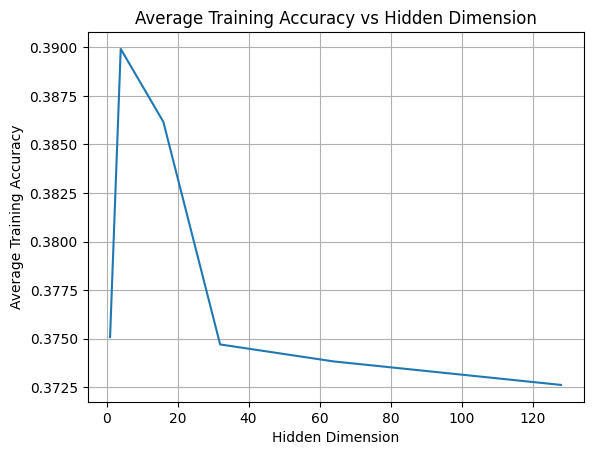

In [ ]:
# Plot: Average Training Accuracy vs Hidden Dim

plt.figure() # Create a new figure for this plot
plt.plot(hidden_dim_array, train_acc)

plt.xlabel('Hidden Dimension')
plt.ylabel('Average Training Accuracy')
plt.title('Average Training Accuracy vs Hidden Dimension')
plt.grid(True)
plt.show()

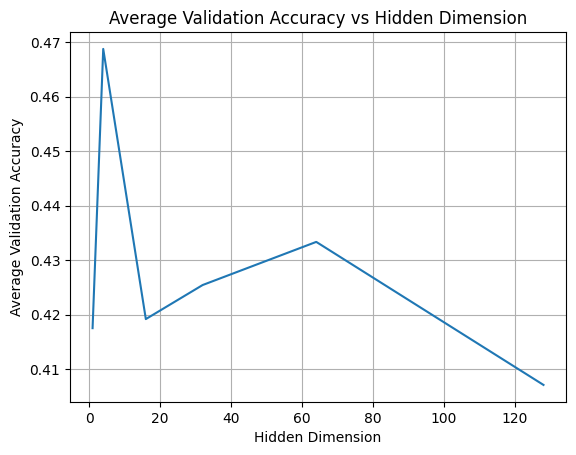

In [ ]:
# Plot: Average Validation Accuracy vs Hidden Dim
# Calculate the average validation accuracy for each hidden dimension

plt.plot(hidden_dim_array, val_acc)

plt.xlabel('Hidden Dimension')
plt.ylabel('Average Validation Accuracy')
plt.title('Average Validation Accuracy vs Hidden Dimension')
plt.grid(True)
plt.show()

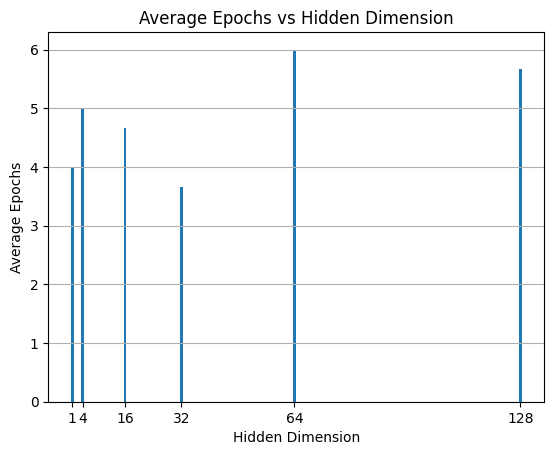

In [ ]:
# Plot: Average Epochs vs Hidden Dim
plt.figure() # Create a new figure for the second plot
plt.bar(hidden_dim_array, avrg_epoch)
plt.xlabel('Hidden Dimension')
plt.ylabel('Average Epochs')
plt.title('Average Epochs vs Hidden Dimension')
plt.xticks(hidden_dim_array) # Ensure all hidden dimensions are shown on the x-axis
plt.grid(axis='y') # Add a grid only to the y-axis for better readability
plt.show()